# spam-detector

%2020-04-19
___

In [14]:
import pandas as pd
import numpy as np
import urllib
import requests
import os

DATABASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/'
LOCAL_DATABASE_PATH = 'spambase'

# Try opening local copies first before fetching from online database
try:
    spam_df = pd.read_csv(os.path.join('spambase-data', 'spambase.data'),
                      header=None, index_col=False)
    print('Reading .data file from local copy of database...')
except OSError:
    spam_df = pd.read_csv(urllib.parse.urljoin(database_url, 'spambase.data'),
                     header=None, index_col=False)
    print('Reading .data file from online of database...')

try:
    with open(os.path.join('spambase-data', 'spambase.names')) as f:
        names_file_text = f.read()
        print('Reading .names file from local copy of database...')
except OSError:
    names_file_text = requests.get(urllib.parse.urljoin(database_url, 'spambase.names')).text
    print('Reading .names file from online database...')

Reading .data file from local copy of database...
Reading .names file from local copy of database...


Attributes are specified in the .names format: http://www.cs.washington.edu/dm/vfml/appendixes/c45.htm

In [15]:
#print(names_file_text)

In [16]:
def get_attribute_names(names_file_text):
    # Anything between a '|' and the end of the line is ignored
    strip_comments = lambda line : line.split('|',1)[0]
    attr_names = []
    read_classes = False
    for line in names_file_text.splitlines():
        if len(line.strip()) == 0 or line[0] == '|':
            continue
        elif not read_classes:
            classes = strip_comments(line).split(',')
            read_classes = True
        else:
            attr_name, attr_type = strip_comments(line).split(':')
            attr_names.append(attr_name)
    return attr_names

# Add classlabel name to last column
spam_df.columns = get_attribute_names(names_file_text) + ['spam']

In [6]:
# Number of Instances: 4601 (1813 Spam = 39.4%)
# Check for null entries: none found
spam_df.isnull().sum().sum()

0

In [7]:
spam_df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,0
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,0
4598,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,0
4599,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,0


In [8]:
def normalise_capital_run_length_data(df):
    crl = df.filter(regex=('capital_run_length*'))
    # Min-Max normalisation
    normalise = lambda col : (col-col.min())/(col.max()-col.min())
    crl = (crl-crl.min())/(crl.max()-crl.min())
    for col_name in crl.columns:
        df[col_name] = normalise(df[col_name])
    return df
    

features = spam_df.drop('spam', axis=1)
#features2 = normalise_capital_run_length_data(features)

In [41]:
import math,random
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

def VAT(R):
    """
    VAT algorithm adapted from matlab version:
    http://www.ece.mtu.edu/~thavens/code/VAT.m

    Args:
        R (n*n double): Dissimilarity data input
        R (n*D double): vector input (R is converted to sq. Euclidean distance)
    Returns:
        RV (n*n double): VAT-reordered dissimilarity data
        C (n int): Connection indexes of MST in [0,n)
        I (n int): Reordered indexes of R, the input data in [0,n)
    """
        
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

In [31]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 9

x_train, x_test, y_train, y_test = train_test_split(features, spam_df['spam'], test_size=0.3, random_state=RANDOM_SEED)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

columns = x_train.columns
train_index = x_train.index
test_index = x_test.index

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_train = pd.DataFrame(data=x_train, index=train_index, columns=columns)
x_test = pd.DataFrame(data=x_train, index=test_index, columns=columns)

# RV, _, _ = VAT(x_train)
# x=sns.heatmap(RV,xticklabels=False,yticklabels=False)
# plt.title('abs')
# x.set(xlabel='Objects', ylabel='Objects')

In [27]:
#x_train

In [36]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

k=10
mi = mutual_info_classif(x_train, y_train)
best_k = np.argsort(mi)[-k:]
x_train = x_train.iloc[:,best_k]
x_test = x_test.iloc[:,best_k]

np.sort(mi)
x_train

,word_freq_hp,word_freq_money,word_freq_free,capital_run_length_total,word_freq_your,word_freq_remove,capital_run_length_average,capital_run_length_longest,char_freq_$,char_freq_!
2553,1.082174,-0.208312,-0.309827,-0.322736,-0.694456,-0.29330,-0.041473,0.003156,-0.333964,-0.308281
2627,-0.327708,-0.208312,-0.309827,-0.417881,0.452160,-0.29330,-0.116203,-0.222600,-0.333964,-0.308281
3559,-0.327708,-0.208312,-0.309827,-0.456643,-0.694456,-0.29330,-0.120020,-0.217897,-0.333964,-0.308281
3731,-0.327708,-0.208312,-0.309827,-0.335069,0.392706,-0.29330,-0.097320,-0.184974,-0.333964,-0.095563
4183,-0.327708,-0.208312,-0.309827,-0.241687,-0.261290,-0.29330,-0.116043,-0.006250,-0.333964,-0.257531
...,...,...,...,...,...,...,...,...,...,...
1149,-0.327708,-0.208312,-0.309827,-0.447834,1.997968,-0.29330,-0.057826,-0.189677,2.268936,0.013496
1787,-0.327708,-0.027787,-0.208594,0.061367,0.324758,-0.29330,-0.090048,0.172474,-0.268564,-0.206781
501,-0.327708,-0.208312,-0.309827,-0.356213,-0.694456,-0.29330,-0.027009,-0.128535,1.444902,0.132273
4444,-0.327708,-0.208312,0.246957,0.033176,-0.320744,-0.29330,0.091353,0.083112,-0.333964,-0.308281


In [167]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=RANDOM_SEED)
model1 = model1.fit(x_train, y_train)

display_metrics(model1, x_test, y_test)

Accuracy       : 0.9572773352643013
ROC AUC        : 0.9833109080251519
TP, FP, FN, TN : [831, 22, 37, 491]
Precision      : 0.9571150097465887
Recall         : 0.9299242424242424



NameError: name 'plt' is not defined

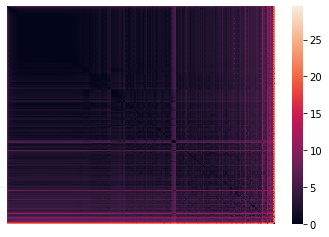

In [44]:
RV, _, _ = VAT(x_train.iloc[:1000,:])
x=sns.heatmap(RV,xticklabels=False,yticklabels=False)
plt.title('abs')
x.set(xlabel='Objects', ylabel='Objects')

In [168]:
from sklearn.neighbors import KNeighborsClassifier

model3 = KNeighborsClassifier(n_neighbors=4)
model3.fit(x_train, y_train)

display_metrics(model3, x_test, y_test)

Accuracy       : 0.9044170890658942
ROC AUC        : 0.9525627020498064
TP, FP, FN, TN : [816, 37, 95, 433]
Precision      : 0.9212765957446809
Recall         : 0.8200757575757576



In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

display_metrics(model1, x_test, y_test)

In [146]:
import sklearn.metrics as skm
def display_metrics(model, x_test, y_test):
    score = model.score(x_test, y_test)
    probabilities = model.predict_proba(x_test)
    y_pred = model.predict(x_test)

    roc_auc = skm.roc_auc_score(y_test, probabilities[:, 1])
    tp, fp, fn, tn = skm.confusion_matrix(y_test, y_pred).ravel()
    precision = skm.precision_score(y_test, y_pred)
    recall = skm.recall_score(y_test, y_pred)
    
    metrics_report = (
        f'Accuracy       : {score}\n'
        f'ROC AUC        : {roc_auc}\n'
        f'TP, FP, FN, TN : {[tp, fp, fn, tn]}\n'
        f'Precision      : {precision}\n'
        f'Recall         : {recall}\n'
    )
    print(metrics_report)

display_metrics(model1, x_test, y_test)
display_metrics(model1, x_train, y_train)
display_metrics(model2, x_test, y_test)
display_metrics(model2, x_train, y_train)

Accuracy       : 0.9539530842745438
ROC AUC        : 0.9867824317018097
TP, FP, FN, TN : [684, 21, 32, 414]
Precision      : 0.9517241379310345
Recall         : 0.9282511210762332

Accuracy       : 0.9994202898550725
ROC AUC        : 0.9999989464298195
TP, FP, FN, TN : [2082, 1, 1, 1366]
Precision      : 0.9992684711046086
Recall         : 0.9992684711046086

Accuracy       : 0.894005212858384
ROC AUC        : 0.957678974652546
TP, FP, FN, TN : [670, 35, 87, 359]
Precision      : 0.9111675126903553
Recall         : 0.804932735426009

Accuracy       : 0.8910144927536232
ROC AUC        : 0.9508270701512681
TP, FP, FN, TN : [1971, 112, 264, 1103]
Precision      : 0.9078189300411522
Recall         : 0.8068763716166789



In [11]:
df.to_csv('a.csv')

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_x)
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

In [37]:
import matplotlib.pyplot as plt

train_x

array([[-0.43160969,  1.13628718],
       [-0.56522658,  4.76459607],
       [ 0.10362038,  2.74547675],
       ...,
       [-0.46489193,  1.03469155],
       [-0.47550461,  1.01049471],
       [-0.76600821, -0.32732229]])

In [ ]:
train_index = x_train.index

pca = PCA(n_components=N_FEATURES)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

print(f'Outputting x_train after PCA as task2bcsv-pca.csv...')
pd.DataFrame(x_train, index=train_index).to_csv('task2bcsv-pca.csv')

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

x_train = pd.DataFrame(x_train, index=train_index)
print('Outputting PCA features pair plot',
      'as task2bpairplot-pca.png...')
visualise_pairplot(x_train, y_train,
                   'World Development (PCA)',
                   'task2bpairplot-pca.png')

return accuracy_score(y_test, y_pred)